

# **Criterion 1: Problem**
&nbsp; 
First, I should clearly state the problem(s) I aim to solve.
&nbsp; 
* Identification of Botnet clusters / independent groups of bots connected to specific C2 servers, and their IP addresses and location.
* Using that information, identification of C2 (command and control) servers, including their IP address and location.
&nbsp; 
I believe that this information will be the most useful to the relevant authorities in facilitating the apprehension of cybercriminals/C2 server owners.
This is because when I identify the C2 server's IP address and location, authorities will have to simply go to the specific area and check through the IP addresses of each device. Upon finding the matching IP address, the owner can be identified as a suspect. My investigation team will therefore have to do little extra work outside of the software development.
&nbsp; 

---

&nbsp; 
I would likely have access to IP address for all relevant actors, as well as the connections between bots and DDOS targets, and markers identifying these two groups. In terms of connections between nodes, I could specify packet flow down into message traffic, console access, or control flow. This would likely be unnecessary, however, as I will explain later that differentiating C2 and bot servers doesn't need specified traffic and it could be quite difficult to do so. (The purpose of network traffic is sometimes hidden or disguised, but it is impossible to hide the raw sent packets themselves, even if their intention is obscured.) 
&nbsp; 
However, I have identified the limitation of C2 servers potentially disguising themselves with VPN's and other faculties. In this case, authorities may be required to intervene. The VPN's IP address will likely be flagged as C2, which could then prompt further investigation (e.g, ordering the company to give up the original C2 server IP address.)
&nbsp; 
In order to achieve my solution, I will likely require a lot of these packet transfers between bots and C2 servers, as well as bots and DDOS victims. This is however largely impossible (as we would not have access to the bot's correspondence outside of the packets sent to DDOS targets.) As a result, we must introduce different ways of obtaining this information. I.e, we must have 'spy bots', which would be intentionally infected by the C2 server/botnet in order to gain limited access to packet flow within the botnet itself.
&nbsp; 

---

&nbsp; 
Overall, we would have four different types of devices:
&nbsp; 
* **Spy bot**: as described
* **Bot**: suspected bots that have sent packets to victim nodes or spy bots during the DDOS attack
* **Recipients**: Devices confirmed not to be bots that have received packets during the DDOS attack
* **C2**: Not initially identified (likely marked as 'Bot' at the start), but would represent the server(s) that are used to control the botnet through command prompts and infection routines.
&nbsp; 
I will also require some way of determining global IP address (or local, depending on the use of the software), and the device's corresponding location. However, for this algorithim i will be assuming that this can be collected just based on the IP address itself. In AOS2 I will probably try and improve the algorithim by taking into account location clustering. However for now I will simplify it slightly. (mostly because I want areas to improve on.)
&nbsp; 

---

&nbsp; 
In order to identify C2 nodes, we would be looking at trying to first find individual botnet clusters (separate sets of bots) that are used in unison within a DDOS attack. Within these clusters, C2 servers generally would have the largest number of connections, and the number of packets sent as part of these connections would be relatively small compared to the number of packets sent to DDOS victims, as C2 servers only need to send out command prompts. It could also be expected that C2 servers will have less or no packet output directed at victims, because the owner likely wants to maintain privacy and their own safety. (However, in the case that the C2 does participate to blend in, the Algorithm should still pick it up.)
&nbsp; 

---

&nbsp; 
The most natural representation of this problem would be with a primary *Directed Weighted Graph ADT**.
&nbsp; 
* Edges could easily be used to represent packet flow, including source, receiver, and volume of packets. , directed from source to reciever. 
* Nodes could represent all devices included in the DDOS attack, and nodes would be associated internal **Dictionary ADT's**, storing the type of node, IP address, and geographical location.
&nbsp; 

---

&nbsp; 
### **ADT specifications/features:**

#### **Directed Weighted Graph (with Dictionary):**
&nbsp; 
> Showcases interconnected data through the uses of nodes (vertices) and edges (connector lines), and can display additional data by attaching ADTs to these constructs (e.g., dict).
> Can be implemented as an adjacency list or matrix or edge set (for this specific problem, we will be expecting a high density/lots of connections, so the matrix will work best.)
&nbsp; 
**Specifications:**
&nbsp; 
```
Import Dictionary, Element, Integer, Boolean, List

addVertex:        Graph x Element x Dictionary -> Graph  
addWeightedEdge:  Graph x Element x Element x Integer    -> Graph  
removeVertex:     Graph x Element              -> Graph  
removeEdge:       Graph x Element x Element              -> Graph  
AdjacentN:         Graph x Element x Element    -> Boolean  
Nodes: Graph -> List
```
&nbsp; 

---

&nbsp; 
#### **Dictionary:**
&nbsp; 
> Similar to a set.
> Unordered collection of key-value pairs: unique keys, with nonunique values associated.
> O(1) access time.
&nbsp; 
**Specifications:**
&nbsp; 
```
Import Element, Boolean

Create:          -> Dictionary  
Get:     Dict x Element          -> Element  
Add:     Dict x Element x Element -> Dict  
Remove:  Dict x Element          -> Dict  
Update:  Dict x Element x Element -> Dict  
HasKey:  Dict x Key              -> Bool  
```
&nbsp; 

---

&nbsp; 
&nbsp; 


### TLDR: I want to find botnet clusters and then identify C2 inside those clusters. I am going to model the problem as a GRAPH. Then we can use C2 locations to catch the pesky buggers



&nbsp; 
&nbsp; 




## **Criterion 2: Algorithm Design and Explanation**
&nbsp; 
&nbsp; 


### Design Patterns Considered

| Pattern                       | Applicability/Notes                                                          |
| ----------------------------- | ---------------------------------------------------------------------------- |
| **Greedy**                    | Fast, scalable. Used in Louvain method for modularity maximization.          |
| **Brute Force**               | Too slow for large graphs (millions of nodes); not feasible.                 |
| **Transform and Conquer**     | Applied conceptually (e.g., removing recipient nodes from clusters).         |
| **Backtracking**              | Not applicable; search space too large, not required.                        |
| **Divide/Decrease & Conquer** | Not suitable; cluster structures cannot be reduced arbitrarily without loss. |

Given the graph size (potentially botnets with millions of nodes), runtime optimization is essential. One algorithm must be greedy to ensure feasibility; the other may trade time for accuracy. (I'll go into more depth later. Essentially we just want a balance between efficiency and accuracy, though. This is done through using at least one greedy/best runtime choice.)

---

### Stage 1: Cluster Detection

#### Option 1: DFS/BFS

* **Method**: Run BFS/DFS from each known spy bot, treating edges as undirected. Track all reachable nodes as potential botnet clusters.
* **Runtime**: Worst-case $O((V+E)V)$ — e.g., if all nodes are spybots.
* **Memory**: Low to medium.
* **Design Pattern**: Transform and conquer (simplifies graph to connected components).
* **Drawbacks**:

  * Overgeneralizes. Bots that target the same recipient may be misgrouped.
  * Does not optimize for modular structure of real-world botnets.

#### Option 2: **Louvain Method (Chosen)**

* **Method**: Iteratively optimizes **modularity** by grouping nodes into dense communities.
* **Runtime**: $O(n \log n)$ average — highly scalable.
* **Memory**: Medium to high.
* **Design Pattern**: **Greedy** — maximizes modularity gain at each step.
* **Justification**:

  * Realistic assumption: bots are densely interconnected, loosely tied to other botnets.
  * Solves the key flaw in DFS/BFS by minimizing cross-cluster edges.
  * Faster and more accurate on large-scale graphs.

#### After clusters are found, we apply a heuristic and **remove recipient-type nodes** to isolate final bot-only structures. This is a transformation step to prepare data for C2 detection.
#### Additionally, we will ensure that clusters generated are correct by removing any that do not contain any spybots. This is because otherwise it may be a cluster comprising only bots and recipients, which will make it difficult to find an accurate estimate of which node is the C2. (as we would need )
#### These heuristics will mean it's more likely we come across a C2 server.
---

### Stage 2: C2 Detection

Using the filtered botnet clusters, we identify C2 nodes — typically those that issue many commands and have high influence. We compare three algorithms:

#### Option 1: Simple Edge Analysis

* **Approach**:

  $$
  \text{Value} = \frac{\text{Total outgoing weight}}{\text{Number of outgoing edges}}
  $$
* **Runtime**: $O(V + E)$
* **Memory**: $O(V)$
* **Design Pattern**: Greedy heuristic.
* **Limitations**: May miss stealthy C2s with low overall activity but high influence.

#### Option 2: In-Degree Centrality

* **Approach**: Identify nodes with the **lowest number of incoming edges**.
* **Justification**: Bots receive many commands, C2s rarely do.
* **Runtime**: $O(V + E)$
* **Memory**: $O(V)$
* **Design Pattern**: Greedy.
* **Limitations**: Assumes static C2 behavior; ignores indirect influence.

#### Option 3: **PageRank (Chosen)**

* **Method**: Iterative scoring based on node importance and influence.
* **Runtime**: $O(k(V + E))$, where $k$ = number of iterations.
* **Memory**: $O(V)$
* **Design Pattern**: **Non-greedy**, iterative refinement.
* **Strength**:

  * Identifies stealthy but **highly influential** nodes.
  * Weighs indirect connections (e.g., C2 → controller bot → bots).

#### Why PR?

Although slightly slower than the other potions, the improved accuracy is critical.(We want the most likely C2 suspects, slightly incorrect clusters have little effect on this.) It overcomes the limitations of purely structural measures like degree centrality. Also, we can afford the runtime increase cause we already optimized cluster detection with Louvain's.
However we will need to do some slight modification. Obviously, we will need another algorithim to iterate over the clusters and apply pagerank. When doing this, we must exlcude any C2 uspects that are also spybots(as we can be sure that the spybots are not C2/accessed directly by the cybercriminal)

---

### **Algorithm Overviews**

#### Louvain Method (Greedy)

* **Goal**: Maximize modularity of communities.
* **How**: Iteratively moves nodes to neighbors' communities if modularity improves.
* **Greedy aspect**: At each step, chooses the move with the highest gain in modularity.
* **Why it works**: Real-world botnets are often modular. bots cluster more tightly than with unrelated nodes.

#### PageRank (Non-Greedy)

* **Goal**: Rank nodes by influence, based on the structure of the network.
* **How**:

  $$
  PR(v) = \sum_{u \in N^{-}(v)} \frac{PR(u)}{d_u}
  $$

  where $d_u$ is the out-degree of node $u$, and the sum is over all nodes linking to $v$.
* **Non-greedy**: It’s a **global, iterative process** . no local-optimum selection.
* **Why it works**: C2s influence many bots directly or indirectly. PageRank naturally highlights these hubs.

---

## Summaryof the final d cision

| Task                  | Algorithm    | Pattern        | Reasoning                                                                |
| --------------------- | ------------ | -------------- | ------------------------------------------------------------------------ |
| **Cluster Detection** | **Louvain(heuristic)**  | **Greedy**     | Fast, modular, avoids DFS/BFS flaws, scalable to millions of nodes.      |
| **C2 Detection**      | **PageRank** | **Non-Greedy** | Prioritizes accuracy and indirect influence, tolerable runtime overhead. |




&nbsp; 
&nbsp; 
### TLDR: I chose the greedy Louvain method for cluster detection and the non-greedy PageRank for C2 identification. This combined approach balances runtime and accuracy, meeting the demands of MASSIVE botnet graphs.
&nbsp; 
&nbsp; 

## **CRITERION 2.5: DEMO GRAPH**
**IMPORTANT**: RUN  pip install networkx matplotlib  in the console first. 

(If you are reading this Mr Ryan, it would be PowerShell. If in VScode you can 'cmd' + '>' to bring it up or click on the search bar at the top of the screen and search for it. Type in '> create new terminal' to find it)





### **Info**

- R1-R8 are recipient nodes
- As you can see, we have no access to the incoming/outgoing packet data of bots outside of the packets sent to victims.
- But, we can simulate visibiulkity with these spy bots. We can see some of the transmissions, and that is more than enough. 
- I've programmed the algorithim already and run it on this graph, and it flags B3,B4,B5 as potential suspects. (excluding weighted edges, which would help the algorithim narrow down further. ) Obviously we cannot be sure of this, but this algorithim is simply meant to give an indication to authorities to then prompt further investigation that is more specialized. 


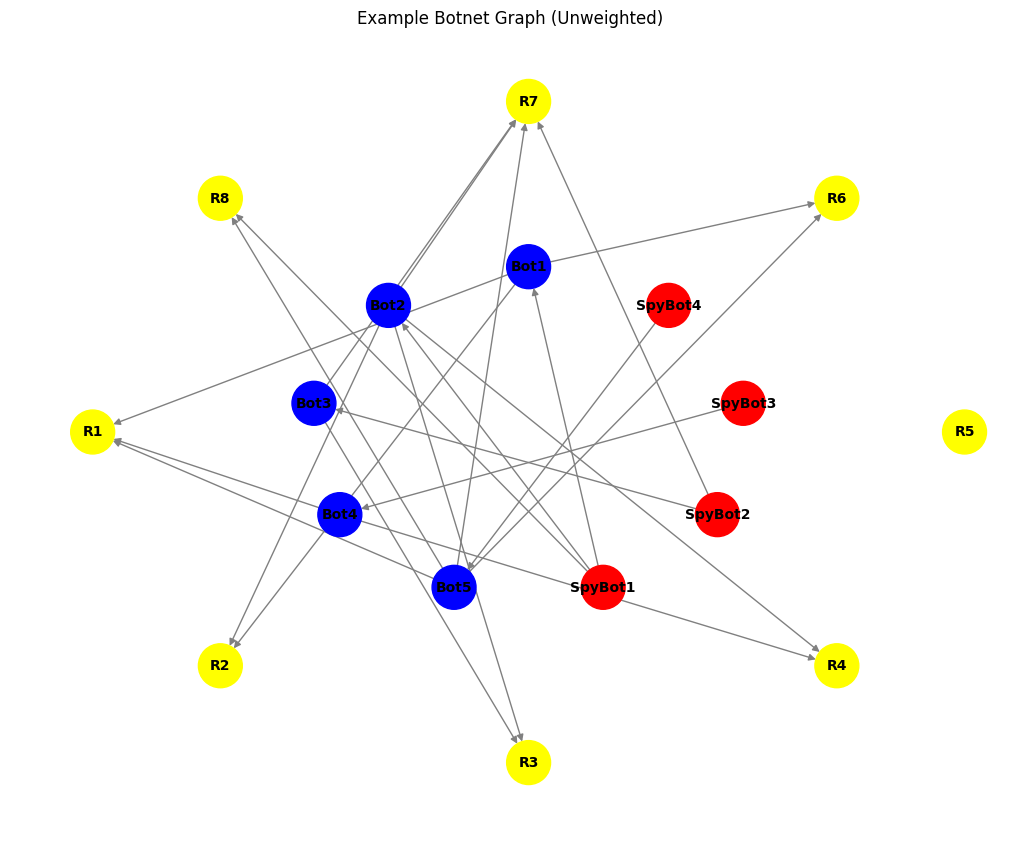

In [5]:
##DEMO GRAPH GENERATION

## IMPORTANT!!!!!!!! MAKE SURE YOU RUN:       pip install networkx matplotlib  

## THIS WILL DOWNLOAD THE REQUIRED LIBRARIES
import networkx as nx
import matplotlib.pyplot as plt
import random

# Create a directed graph
G = nx.DiGraph()

# Define node groups
bots = ['Bot1', 'Bot2', 'Bot3', 'Bot4', 'Bot5']
spybots = ['SpyBot1', 'SpyBot2', 'SpyBot3', 'SpyBot4']
recipients = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']

# Add nodes with types
for b in bots:
    G.add_node(b, nodetype='Bot')
for s in spybots:
    G.add_node(s, nodetype='SpyBot')
for r in recipients:
    G.add_node(r, nodetype='Recipient')

# Only allow edges from SpyBots to Bots (simulating captured communication)
G.add_edge('SpyBot1', 'Bot1')
G.add_edge('SpyBot1', 'Bot2')
G.add_edge('SpyBot2', 'Bot3')
G.add_edge('SpyBot3', 'Bot4')
G.add_edge('SpyBot4', 'Bot5')

# Bots send traffic to multiple recipients
for bot in bots:
    targets = random.sample(recipients, k=random.randint(2, 4))  # 2 to 4 recipients per bot
    for r in targets:
        G.add_edge(bot, r)

# Optional: SpyBots send to some recipients too
G.add_edge('SpyBot1', 'R8')
G.add_edge('SpyBot2', 'R7')

# Position: core (bots & spybots) in middle, recipients around
core_nodes = bots + spybots
pos = nx.shell_layout(G, [core_nodes, recipients])

# Color nodes
color_map = []
for _, attr in G.nodes(data=True):
    if attr['nodetype'] == 'SpyBot':
        color_map.append('red')
    elif attr['nodetype'] == 'Bot':
        color_map.append('blue')
    else:
        color_map.append('yellow')

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw(
    G, pos, with_labels=True, node_color=color_map,
    node_size=1000, font_size=10, font_weight='bold', edge_color='gray', arrows=True
)
plt.title("Example Botnet Graph (Unweighted)")
plt.axis('off')
plt.show()



## Criterion 3: Pseudocode
```text
START

// Assumptions/Used ADTS:
// Graph: Weighted directed graph with nodes and edges
// Dict: Dictionary (key-value pairs)
// Set: Unordered collection of unique elements
// List: Ordered collection of elements based on index
// Queue: Ordered collection of elements based on insertion time. 



Import PacketData  // List of (sourceIP, destinationIP, packetCount)
Import MetaData    // Dict with device's IP associated with {location,type} 


// Load packet data into a graph
Function LoadGraphFromPacketData(PacketData)
    graph ← new Graph()
    For each packetval in PacketData: //iterating over packets
        src ← packetval.sourceIP //This is the way i will access the edges/packet data initially. 
        dest ← packetval.destinationIP
        weight ← packetval.count

        If Not graph.HasVertex(src): 
            If MetaData.ContainsKey(src):
                graph.AddVertex(src, MetaData.get(src))
            Else:
                graph.AddVertex(src, EmptyMetadata()) //edge cases, if no metadata.

        If Not graph.HasVertex(dest):
            If MetaData.ContainsKey(dest):
                graph.AddVertex(dest, MetaData.get(dest))  //edge cases, if no metadata.
            Else:
                graph.AddVertex(dest, EmptyMetadata())

        graph.AddEdge(src, dest, weight)
    return graph


// Small function to create a set of spybots for later use in the cluster detection algorithim. 
Function IdentifySpyBots(graph)
    spyBots ← Set()
    For each node in graph.Nodes:
        If node.get('type', "") == "SpyBot":
            spyBots.Add(node)
    return spyBots


// Simple Louvain clustering algorithim. Heuristics applied later.
Function LouvainClustering(graph)
    visited ← Set()
    clusters ← List()

    For each node in graph.Nodes:
        If node not in visited:
            cluster ← new Graph()
            queue ← [node]
            While queue not empty:
                current ← queue.peek() // Simplified queue operation here. Usually we just use pop(0) but this is what VCAA wants. (peek and then dq)
                queue.dequeue()
                If current in visited:
                    Continue
                visited.Add(current)
                metadata ← graph.GetMetadata(current)
                cluster.AddVertex(current, metadata)
                neighbors ← Union(graph.GetOutgoingNeighbors(current), graph.GetIncomingNeighbors(current))
                For each neighbor in neighbors:
                    cluster.AddVertex(neighbor, graph.GetMetadata(neighbor))
                    weight ← graph.GetEdgeWeight(current, neighbor)
                    cluster.AddEdge(current, neighbor, weight)
                    If neighbor not in visited:
                        queue.enqueue(neighbor)
            clusters.Add(cluster)
    return clusters


// Heuristic to keep only clusters that contain SpyBots
Function DetectClusters(graph, spyBots)
    clusters ← LouvainClustering(graph)
    filteredClusters ← new List()
    For each cluster in clusters:
        For each node in cluster.Nodes:
            If node in spyBots:
                filteredClusters.Add(cluster)
                Break
    return filteredClusters


// small function to remove recipient nodes from a cluster
Function RemoveRecipientNodes(cluster)
    For each node in CopyOf(cluster.Nodes):
        If node.get('type', "") == "Recipient":
            cluster.RemoveVertex(node)
    return cluster


// Basic PageRank algorithm, no explanation needed as this is a base(unchanged) implementation
Function PageRank(graph, dampingFactor, iterations)
    N ← graph.Size()
    rank ← Dict()
    For each node in graph.Nodes:
        rank[node] ← 1 / N

    For i from 1 to iterations:
        newRank ← new Dict()
        For each node in graph.Nodes:
            newRank[node] ← (1 - dampingFactor) / N

        For each node in graph.Nodes:
            neighbors ← graph.GetOutgoingNeighbors(node)
            If Length(neighbors) > 0:
                For each neighbor in neighbors:
                    newRank[neighbor] ← newRank[neighbor] + dampingFactor * (rank[node] / Length(neighbors))

        rank ← newRank
    return rank


// Identify Command & Control (C2) server using PageRank , 
Function IdentifyC2Server(cluster)
    pagerank ← PageRank(cluster, 0.85, 3)
    maxScore ← 0 // We will keep track of the highest PR value(s) (if multiple equal highest the set should account for it.)
    c2Candidates ← Set()

    For each node in pagerank.keySet():
        score ← pagerank.Get(node) 
        If score > maxScore:  // Set a new max score 
            c2Candidates.Clear()
            c2Candidates.Add(node)
            maxScore ← score
        Else if score == maxScore:
            c2Candidates.Add(node)

    return Difference(c2Candidates,SpyBots) // We will only return the C2 candidates that are NOT spybots.


// Main Execution
graph ← LoadGraphFromPacketData(PacketData)
spyBots ← IdentifySpyBots(graph)
clusters ← DetectClusters(graph, spyBots)

If Length(clusters) == 0:
    Print("No clusters with SpyBots detected.")
Else:
    For each cluster in clusters:
        cleanedCluster ← RemoveRecipientNodes(cluster)
        Print("C2 cluster:",cleanedCluster.Nodes) //assuming it just prints out IP address
        c2Candidates ← IdentifyC2Server(cleanedCluster)

        if length(c2Candidates) > 1: // More than one candidate we must account for
            for candidate in c2Candidates:
                Print("Possible C2 server for cluster:",candidate,candidate.get('location')) 
        else:
            Print("Possible C2 server for cluster:",c2Candidates,c2Candidates.get('location')) 

```

## **Criterion 4: Final Justifications**


Suitability:
This algorithm is specifically designed to address the real-world limitations of botnet detection using network packet data. In practical scenarios, we cannot reliably capture packet exchanges between bots directly.(it is either encrypted or just unreachable.) To solve this, the design incorporates "SpyBots" - devices that were intentionally infected and are able to be accessed by authorities, recording data during the DDOS attack to then be viewed and parsed later. This simulates partial network visibility, allowing for accurate detection of potential C2 devices. Additionally, by not specializing or catergorizing packet data, we avoid loss of efficacy in cases where incoming data is heavily encrypted, real-life application is uncompromised. By only considering clusters that include SpyBots, the system filters out noise (like benign recipient traffic) and avoids making further unrealistic assumptions about full visibility. This makes the solution not only effective but also operationally feasible. It balances analytical rigor with the constraints of network forensics, unlike brute-force or full-topology reconstruction methods that are computationally expensive or based on data **we don’t realistically have**. 😭

Coherence:
The algorithm is exceptionally modular, structured, and logically ordered. It begins with parsing packet data into a graph structure, enriched with metadata that tags each node as a Bot, SpyBot, or Recipient. From there, SpyBots are used to guide a targeted clustering phase, using Louvain clustering, ensuring only relevant portions of the graph are analyzed. Recipient nodes are then stripped out of clusters to focus purely on internal control relationships. Finally, the PageRank algorithm is used to identify which node(s) exert the most influence, pointing to likely C2 servers. Each function serves a distinct purpose, and the system flows smoothly from input to output, ensuring reliability and ease of debugging.

Fitness for Purpose:
This solution achieves its goal: to support cyber investigators in identifying potential C2 servers in a botnet. It’s intentionally designed to operate at a high level of abstraction, returning key details like IP addresses and geolocations of suspicious nodes. These results are structured to be actionable even by non-specialist users: (i.e, the average police officer)who may not have deep technical knowledge. Provided they can supply the necessary input data (which to be honest, could likely be gathered by our cybersecurity team), the algorithm can run autonomously and deliver meaningful leads for further investigation. 